In [2]:
library(DEqMS)
library(patchwork)
library(tidyverse)

source("../../evaluation_utils/evaluation/DE_analysis.R")
source("../../evaluation_utils/plots/DE_plots.R")
source("../../evaluation_utils/plots/eda_plots.R")
source("../../evaluation_utils/filtering/filtering_normalization.R")

library(jsonlite)

Loading required package: ggplot2

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Loading required package: matrixStats

Warning message:
“package ‘matrixStats’ was built under R version 4.2.3”
Loading required package: limma

Warning message:
“package ‘tidyverse’ was built under R version 4.2.2”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.2”
Warning message:
“package ‘readr’ was built under R version 4.2.2”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.2”
Warning message:
“package ‘lubridate’ was built under R version 4.2.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.

In [7]:
create_plots <- function(pg_matrix, metadata, name, plot_file_prefix, shape_col="Pool", width=14){

    # log2 transform for plots
    pg_matrix <- pg_matrix %>% 
      mutate(across(everything(), 
                      ~ {.x <- log2(.)
                      replace(.x, .x < 0 | is.infinite(.x), NA)
                      }))
    # plots
    plot_pca <- pca_plot(pg_matrix, metadata, 
        title=paste0(name, " PCA"), 
        quantitative_col_name='file', col_col='condition', shape_col=shape_col)

    plot_boxplot <- boxplot_pg(pg_matrix, metadata, 
        title=paste0(name, " Boxplot"), 
        color_col='condition', quantitativeColumnName='file')

    plot_density <- plotIntensityDensityByPool(pg_matrix, metadata, 
        title=paste0(name, " Density"), 
        poolColumnName='condition', 
        quantitativeColumnName='file')
        
    plot_heatmap <- heatmap_plot(pg_matrix, metadata, name, condition="condition", lab=shape_col)

    layout <- (plot_density | plot_pca) /
            (plot_boxplot | plot_heatmap)
    # save plot
    ggsave(file = paste0(plot_file_prefix, "_plots.svg"), plot = layout, width = width, height = 10)
}


# Central run

In [8]:
filter_list_META = list("01_smaller_lib_balanced_PG_MajorPG" = list())

analyzed_proteins <- list()



Dataset:  01_smaller_lib_balanced_PG_MajorPG 
	Number of proteins:  628 
	Number of samples:  65 
Filtering out features that have NAs in all columns
	Before filtering: 628 65 
	After filtering: 628 65 
Filtering by condition - two not-NA per condition
	Before filtering: 628 65 
	After filtering: 628 65 
Filtering by center - two not-NA per center
	Before filtering: 628 65 
	After filtering: 363 65 
Rows after all filters: 363 
IRS normalization for center:  Center1 
IRS normalization for center:  Center2 
IRS normalization for center:  Center3 


No id variables; using all as measure variables

Warning message:
“Removed 637 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 637 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 637 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Partial NA coefficients for 38 probe(s)”


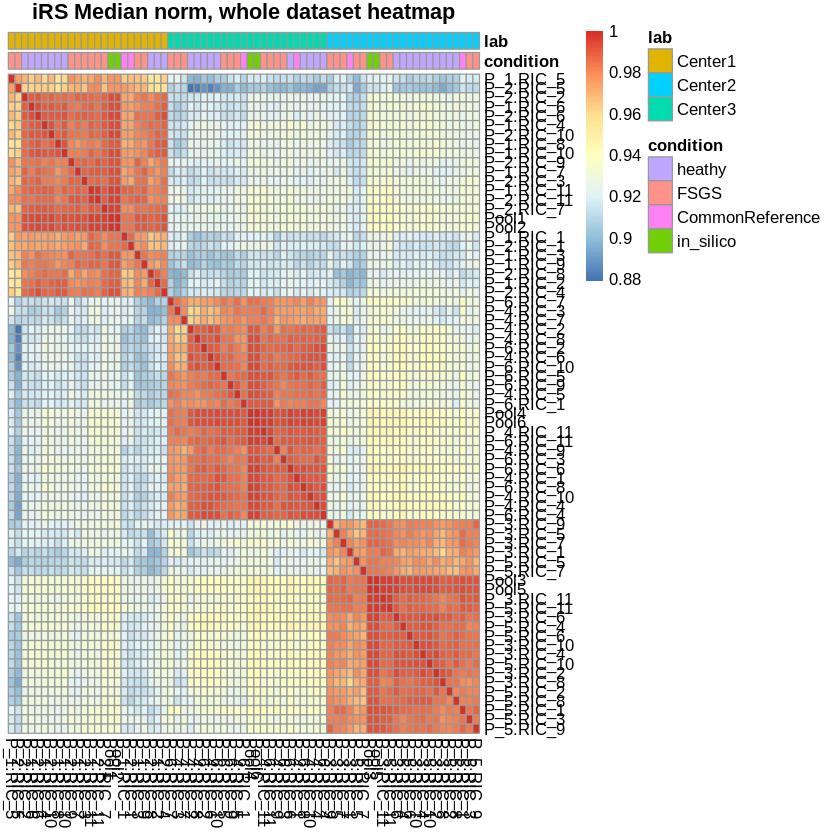

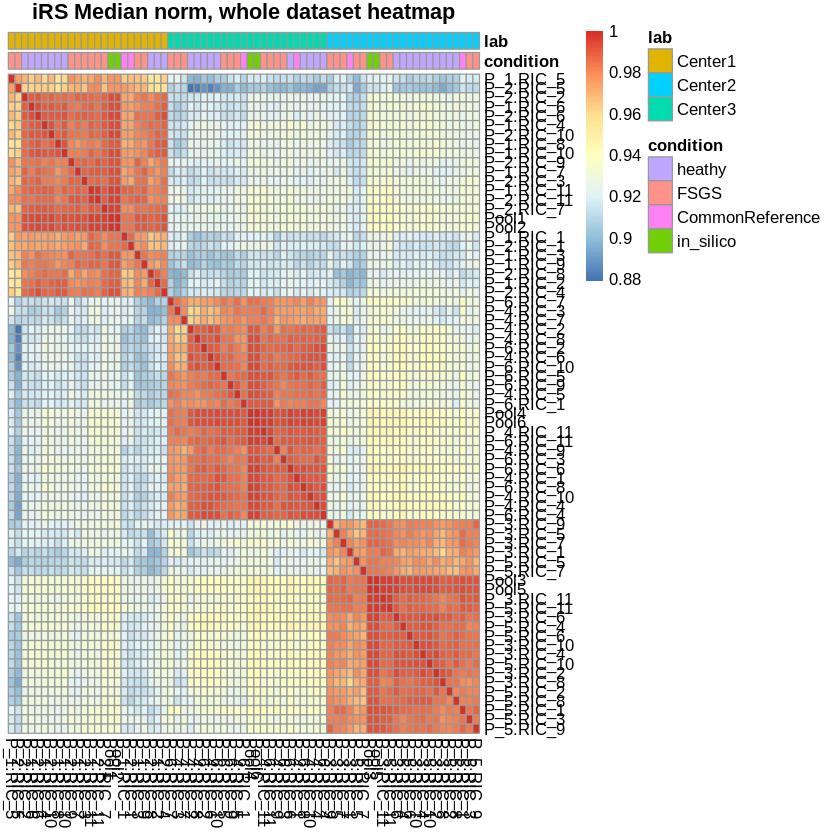

In [31]:
datasets_list = c('01_smaller_lib_balanced_PG_MajorPG')
labs_list = c('Center1', 'Center2', 'Center3')

for (dataset in datasets_list){
  path_to_reports = paste0('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/', dataset, "/")
  output_path = paste0('/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/', dataset, '/results/')
  if(!dir.exists(output_path)){
    dir.create(output_path)
  }

  central_intensities = NULL
  central_counts = NULL
  central_batch_info = read_tsv(paste0(path_to_reports, 'metadata.tsv'), show_col_types = FALSE)
  central_batch_info <- central_batch_info %>%
    mutate(Group = ifelse(Group == "Common Reference", "CommonReference", Group)) %>%
    mutate(
      file = Quantitative.column.name,
      lab = Center,
      condition = Group
    )

  for (name in labs_list) {

    intensities = read_tsv(paste0(path_to_reports, name, '/pg_intensities.tsv'), show_col_types = FALSE)
    counts = read_tsv(paste0(path_to_reports, name, '/pg_counts.tsv'), show_col_types = FALSE)

    if(is.null(central_intensities)){
      central_intensities = intensities
      central_counts = counts
    } else {
      central_intensities = full_join(central_intensities, intensities, by = 'Majority.protein.IDs')
      central_counts = full_join(central_counts, counts, by = 'Majority.protein.IDs')
    }
  }

  cat('\n\nDataset: ', dataset, "\n")
  cat('\tNumber of proteins: ', nrow(central_intensities), '\n')
  cat('\tNumber of samples: ', ncol(central_intensities)-1, '\n')

  central_intensities <- central_intensities %>% column_to_rownames('Majority.protein.IDs')
  # save for RBE 
  # write.table(central_intensities, file = paste0('/home/yuliya/repos/other/removeBatch/evaluation_data/proteomics/before/', dataset, '_central_intensities.tsv'), sep = "\t", quote = FALSE, row.names = TRUE)
  # write.table(central_batch_info, file = paste0('/home/yuliya/repos/other/removeBatch/evaluation_data/proteomics/before/', dataset, '_central_batch_info.tsv'), sep = "\t", quote = FALSE, row.names = FALSE) 
  central_counts <- central_counts %>% column_to_rownames('Majority.protein.IDs')
  central_intensities <- central_intensities[, central_batch_info$file]

  # filter by condition
  intensities <- filter_na_proteins(central_intensities, central_batch_info, "file")
  central_intensities <- filter_by_condition(central_intensities, central_batch_info, 
        'file', c('heathy', 'FSGS'), 'condition')

  filter_list_META[[dataset]][['Central']] <- rownames(central_intensities)

  central_intensities <- filter_per_center(central_intensities, central_batch_info, "file",
    unique(central_batch_info$lab), 'lab')
  
  cat("Rows after all filters:", nrow(central_intensities), "\n")
  analyzed_proteins[[dataset]] <- rownames(central_intensities)
  

  # NORMALIZATION
  # median normalization
  medianNorm_intensities <- medianNorm(central_intensities) %>% as.data.frame()
  rownames(medianNorm_intensities) <- rownames(central_intensities)
  central_intensities <- medianNorm_intensities

  corrected_intensities <- NULL
  updates_metadata <- NULL

  # irs with in silico reference
  for(center in labs_list){
    cat("IRS normalization for center: ", center, "\n")
    center_intensities <- central_intensities[, central_batch_info$lab == center]
    center_batch_info <- central_batch_info[central_batch_info$lab == center, ]

    irs_res <- irsNorm_in_silico_single_center(
      center_intensities, center_batch_info,
      center = center
    ) 
    # add to the central data
    if(is.null(corrected_intensities)){
      corrected_intensities = irs_res$corrected_data
      updates_metadata = irs_res$metadata
    } else {
      corrected_intensities = cbind(corrected_intensities, irs_res$corrected_data)
      updates_metadata = rbind(updates_metadata, irs_res$metadata)
    }
  }
  
  central_batch_info <- updates_metadata %>% as.data.frame()
  central_intensities <- corrected_intensities %>% as.data.frame()
  central_intensities <- central_intensities[, central_batch_info$file %>% unlist()]
  
  central_batch_info <- central_batch_info %>%
    mutate(
        file = as.character(file),
        lab = as.factor(as.character(lab)),
        Pool = as.factor(as.character(Pool)),
        condition = factor(as.character(condition), levels = c('heathy', 'FSGS', "CommonReference", "in_silico"))
      )
  rownames(central_batch_info) <- central_batch_info$file

  # plot results
  create_plots(central_intensities, central_batch_info, "iRS Median norm, whole dataset",
    "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/01_smaller_lib_balanced_PG_MajorPG/IRS_median",
    shape_col = "lab", width = 20)
  
  central_intensities <- log2(central_intensities + 1)

  # select minimal count across column for each protein (with na.rm = TRUE)
  central_counts$count <- apply(central_counts, 1, min, na.rm = TRUE)
  central_counts <- central_counts %>% select(count)

  # run DE analysis
  design <- make_design(central_batch_info, 'condition', 'Pool')
  contrasts <- makeContrasts(heathy-FSGS, levels = colnames(design))
  de_results <- run_DE(central_intensities, central_counts, design, contrasts)
  de_results <- de_results %>% rownames_to_column('Protein')
  write.table(de_results, file = paste0(output_path, "/central_res.tsv"), sep = "\t", quote = FALSE, row.names = FALSE)

  # plot volcano plot
  plot_result <- volcano_plot(
    de_results, paste(dataset, "central", ", healthy/FSGS"),
    pval_threshold = 0.05, logfc_threshold = 0.25,
    show_names = FALSE
  )
  ggsave(file = paste0(output_path, '/central_volcano_plot.svg'), plot = plot_result, width = 8, height = 5)
}


# Separate run for meta

In [9]:
options(warn=-1)
datasets_list = c('balanced', 'imbalanced')
labs_list = c('lab_A', 'lab_B', 'lab_C', 'lab_D' , 'lab_E')

# empty plot
x <- ggplot() + theme_minimal()

for(dataset in datasets_list){
  plots_list = list()
  cat('\n\nDataset: ', dataset, "\n")

  path_to_reports = paste0('/home/yuliya/repos/cosybio/FedProt/data/bacterial_data/', dataset, '/')
  
  for (name in labs_list) {
    output_path = paste0('/home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/Meta_DE/', dataset, '/')
    cat('\nLab: ', name, "\n")

    batch_info = read_tsv(paste0(path_to_reports, name, '/metadata.tsv'), show_col_types = FALSE)
    intensities = read_tsv(paste0(path_to_reports, name, '/protein_groups_matrix.tsv'), show_col_types = FALSE)
    counts = read_tsv(paste0(path_to_reports, name, '/protein_counts.tsv'), show_col_types = FALSE)

    intensities <- intensities %>% column_to_rownames('rowname')
    counts <- counts %>% column_to_rownames('rowname')
    intensities <- intensities[, batch_info$file]
    
    filter_list_META[[dataset]][[name]] <- rownames(intensities)

    intensities <- intensities[analyzed_proteins[[dataset]],]
    cat("Rows after all filters:", nrow(intensities), "\n")
    intensities <- log2(intensities + 1)

    # run DE
    design <- make_design(batch_info, 'condition')
    contrasts <- makeContrasts(Glu-Pyr, levels = colnames(design))
    de_results <- run_DE(intensities, counts, design, contrasts)
    de_results <- de_results %>% rownames_to_column('Protein')
    write.table(de_results, file = paste0(output_path, name, '_res_FULL.tsv'), sep = "\t", quote = FALSE, row.names = FALSE)


    # plot volcano plots
    if(name == 'lab_E'){
        plot_separate <- volcano_plot(
        de_results, paste(dataset, name, ", Glu/Pyr"),
        pval_threshold = 0.01, logfc_threshold = 0.58,
        show_names = FALSE
      )
    } else {
      plot_separate <- volcano_plot(
        de_results, paste(dataset, name, ", Glu/Pyr"),
        pval_threshold = 0.01, logfc_threshold = 0.58,
        show_names = FALSE, show_legend = FALSE
      )
    }
    plots_list[[name]] = plot_separate
  }

  layout <- (plots_list[['lab_A']] | plots_list[['lab_B']] | plots_list[['lab_C']]) /
            (plots_list[['lab_D']] | plots_list[['lab_E']] | x)
  # save plot
  ggsave(file = paste0(output_path, "volcano_plots.svg"), plot = layout, width = 15, height = 8)
}


write_json(filter_list_META, "/home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/Meta_DE/filter_list_META.json")



Dataset:  balanced 

Lab:  lab_A 
Rows after all filters: 0 


ERROR: Error in lmFit(intensities, design): expression matrix has zero rows


In [ ]:
meta_filter <- list()


# prepare filter for meta-analyses
for(dataset in datasets_list){
  cat('\n\nDataset: ', dataset)
  for (name in labs_list) {
    if(is.null(meta_filter[[dataset]])){
      meta_filter[[dataset]] <- filter_list_META[[dataset]][[name]]
    } else {
      meta_filter[[dataset]] <- intersect(meta_filter[[dataset]], filter_list_META[[dataset]][[name]])
    }
  }
  cat("\n\tIntersection length:",  length(meta_filter[[dataset]]))
}



Dataset:  balanced
	Intersection length: 2273

Dataset:  imbalanced
	Intersection length: 2273

In [ ]:
for(dataset in datasets_list){
  for (name in labs_list) {
    # reaed results
    de_results <- read_tsv(paste0('/home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/Meta_DE/', dataset, '/', name, '_res_FULL.tsv'), show_col_types = FALSE)
    de_results <- de_results %>% filter(Protein %in% meta_filter[[dataset]]) %>%
      arrange(desc(Protein))
    cat('\nDataset: ', dataset, 'Lab: ', name, 'Number of DE proteins: ', nrow(de_results))
    write.table(de_results, file = paste0('/home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/Meta_DE/', dataset, '/', name, '_res.tsv'), sep = "\t", quote = FALSE, row.names = FALSE)
    }
}


Dataset:  balanced Lab:  lab_A Number of DE proteins:  2272
Dataset:  balanced Lab:  lab_B Number of DE proteins:  2272
Dataset:  balanced Lab:  lab_C Number of DE proteins:  2272
Dataset:  balanced Lab:  lab_D Number of DE proteins:  2272
Dataset:  balanced Lab:  lab_E Number of DE proteins:  2272
Dataset:  imbalanced Lab:  lab_A Number of DE proteins:  2271
Dataset:  imbalanced Lab:  lab_B Number of DE proteins:  2271
Dataset:  imbalanced Lab:  lab_C Number of DE proteins:  2271
Dataset:  imbalanced Lab:  lab_D Number of DE proteins:  2271
Dataset:  imbalanced Lab:  lab_E Number of DE proteins:  2271

run metaanalyses

In [ ]:
# cd /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/Meta_DE/balanced/

# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_MetaDE.R /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/Meta_DE/balanced/ lab_A lab_B lab_C lab_D lab_E
# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_MetaVolcanoR.R /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/Meta_DE/balanced/ lab_A lab_B lab_C lab_D lab_E
# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_RankProd.R /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/Meta_DE/balanced/ lab_A lab_B lab_C lab_D lab_E

# cp /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/Meta_DE/balanced/MA_* /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/balanced/results/

In [ ]:
# cd /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/Meta_DE/imbalanced/

# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_MetaDE.R /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/Meta_DE/imbalanced/ lab_A lab_B lab_C lab_D lab_E
# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_MetaVolcanoR.R /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/Meta_DE/imbalanced/ lab_A lab_B lab_C lab_D lab_E
# Rscript /home/yuliya/repos/cosybio/FedProt/evaluation_utils/meta_code/run_RankProd.R /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/Meta_DE/imbalanced/ lab_A lab_B lab_C lab_D lab_E

# cp /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/Meta_DE/imbalanced/MA_* /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/imbalanced/results/